In [43]:
import numpy as np
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector
from py_pol.mueller import Mueller

from py_pol import degrees

import matplotlib.pyplot as plt

In [18]:
def Cargar_Calibracion_SLM(type="Jones"):
    """Funcion para cargar la calibración del SLM y convertirlo a un objeto py_pol.
    
    Args:
        type (str): Tipo de objeto, Jones o Mueller.
        
    Returns:
        M (Jones_matrix o Mueller): Resultado"""
    data = np.load("SLM_Jones_components.npz")
    components = [data["J0"] * np.exp(1j * data["d0"]),
                 data["J1"] * np.exp(1j * data["d1"]),
                 data["J2"] * np.exp(1j * data["d2"]),
                 data["J3"] * np.exp(1j * data["d3"])]
    M = Jones_matrix().from_components(components)
    
    if type.lower() == "mueller":
        M2 = Mueller().from_Jones(M)
        M = M2
    
    return M                  
    

In [23]:
def Calculate_Transmission(angles, Jslm, E0=None):
    """Function that calculates the transmission (amplitude and phase) of the PSG + SLM + PSA system.

    Args:
        angles (np.ndarray): Rotation angles of P1, Q1, Q2 and P2.
        Jslm (Jones_matrix): Jones matrix of the SLM.
        states (bool): If True, angles is [PSG_az, PSG_el, PSA_az, PSA_el] instead of rotation angles. Default: False.
        E0 (Jones_vector or None). Source Jones vector. If None, circular polarization is used.

    Returns:
        int (np.ndarray): Intensity of final state.
        phase (np.ndarray): Global phase of final state.
    """
    # Create objects
    if E0 is None:
        E0 = Jones_vector().circular_light(intensity=2)
        
    if np.isnan(angles[0]) or angles[0] < 0:
        P1 = Jones_matrix().vacuum()
    else:
        P1 = Jones_matrix().diattenuator_perfect(azimuth=angles[0])
    if np.isnan(angles[1]) or angles[1] < 0:
        Q1 = Jones_matrix().vacuum()
    else:
        Q1 = Jones_matrix().quarter_waveplate(azimuth=angles[1])
    if np.isnan(angles[2]) or angles[2] < 0:
        Q2 = Jones_matrix().vacuum()
    else:
        Q2 = Jones_matrix().quarter_waveplate(azimuth=angles[2])
    if np.isnan(angles[3]) or angles[3] < 0:
        P2 = Jones_matrix().vacuum()
    else:
        P2 = Jones_matrix().diattenuator_perfect(azimuth=angles[3])
    # print(P1, Q1, Q2, P2, sep='\n')

    # Calculate final state
    Efinal = (P2 * Q2) * (Jslm * (Q1 * P1 * E0))

    # Extract phase and amplitude
    phase = Efinal.parameters.global_phase()
    phase -= phase[0]
    phase = phase % (2 * np.pi)
    amplitude = np.sqrt(Efinal.parameters.intensity())

    return amplitude, phase, Efinal

## Cargar Matrices de polarización de Holoeye

In [44]:
S_incident=Jones_vector('incident')
S_incident.linear_light(azimuth=45*degrees)

incident = 
[+0.707+0.000j ]   
[+0.707+0.000j ]   

In [24]:
Jslm=Cargar_Calibracion_SLM(type="Jones")

In [25]:
type(Jslm), Jslm.shape

(py_pol.jones_matrix.Jones_matrix, [256])

## Ejemplo de sistema con polarizadores

In [96]:
##Interesantes

angles=np.array((0,45*degrees,0,90*degrees))


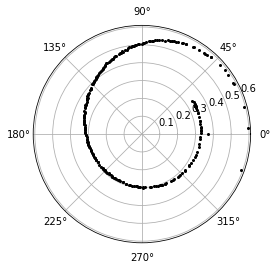

In [107]:
angles=np.array((0,45*degrees,0,90*degrees))
amplitude, phase, fields=Calculate_Transmission(angles, Jslm, E0=S_incident)

plt.polar(phase, amplitude, 'k.', ms=4)

## Ejemplo de sistema sin polarizadores

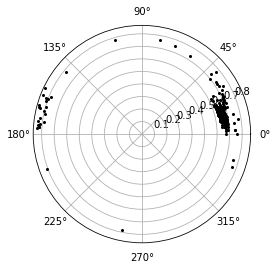

In [110]:
S_incident=Jones_vector('incident')
#S_incident.linear_light(azimuth=90*degrees)
S_incident.circular_light(kind='r')

angles=np.array((np.nan, np.nan, np.nan, np.nan))
amplitude, phase, fields=Calculate_Transmission(angles, Jslm, E0=S_incident)

plt.polar(phase, amplitude, 'k.', ms=4)

## Captura de campos fabricables

In [111]:
Ex,Ey=fields.parameters.components()

In [112]:
Esx_posible=Ex
Esy_posible=Ey

## Distancias entre campo escalar y fabricable
Estamos en modo escalar. Queremos calcular las distancias entre un campo complejo $A(x,y)e^{i \phi(x,y)}$ y unos elementos fabricables $A_f(x,y)e^{i \phi_f(x,y)}$. Pasamos a campos Er y Ei pues es más sencillo medir distancias

In [113]:
def distances_scalar(DOE, Es_posible):
    
    DOE_r = np.real(DOE)
    DOE_i = np.imag(DOE)
    Ef_r = np.real(Es_posible)
    Ef_i = np.imag(Es_posible)
    
    x1=np.stack((DOE_r,DOE_i),axis=2)
    x2=np.stack((Ef_r, Ef_i), axis=1)
    distance = (x1[np.newaxis,:,:,:]-x2[:,np.newaxis, np.newaxis, :])**2
    distances=np.sqrt(distance.sum(axis=3))
    i_mins=(distances==distances.min(axis=0))
    i_positions=np.argmax(i_mins, axis=0)
    DOE_new=np.zeros_like(i_positions,dtype=complex)
    for i, E_posible in enumerate(Es_posible):
        DOE_new[i_positions==i]=E_posible

    return DOE_new, i_positions, distances

In [114]:
size_x_DOE, size_y_DOE = 20,19
size_fabricable = 8

DOE= np.random.rand(size_x_DOE, size_y_DOE)*np.exp(1j*2*np.pi*np.random.rand(size_x_DOE, size_y_DOE))
Es_posible=np.random.rand(size_fabricable)*np.exp(1j*2*np.pi*np.random.rand(size_fabricable))
print(DOE.shape, Es_posible.shape)
Es_posible=np.array((0,1.),dtype=complex)
Es_posible=np.array((0,1j),dtype=complex)
Es_posible=np.array((0,0.5,1.),dtype=complex)

print(Es_posible.shape)

(20, 19) (8,)
(3,)


In [115]:
DOE_new, i_positions, distances=distances_scalar(DOE, Es_posible)

In [116]:
distances.mean()

0.7496447200834404

## Distancias entre campo vectorial y fabricable
Estamos en modo escalar. Queremos calcular las distancias entre un campo complejo [$A_x(x,y)e^{i \phi_x(x,y)}$,  $A_y(x,y)e^{i \phi_y(x,y)}$] -y unos elementos fabricables [$A_xf(x,y)e^{i \phi_xf(x,y)}$, $A_y f(x,y)e^{i \phi_yf(x,y)}$]. Pasamos a campos Er y Ei pues es más sencillo medir distancias

## NxMx4

 - DOE representa los vectores de stokes de la imagen (DOE) NxM. El 4 representa $(E_x^r, E_x^i, E_y^r, E_y^i)$ 
 - S_posible representa las posibles soluciones que en este caso son 6


In [56]:
def distances_vector(DOEx, DOEy, Esx_posible, Esy_posible):
    
    DOEx_r = np.real(DOEx)
    DOEx_i = np.imag(DOEx)
    DOEy_r = np.real(DOEy)
    DOEy_i = np.imag(DOEy)
    
    Efx_r = np.real(Esx_posible)
    Efx_i = np.imag(Esx_posible)
    Efy_r = np.real(Esy_posible)
    Efy_i = np.imag(Esy_posible)
    
    x1=np.stack((DOEx_r,DOEx_i, DOEy_r, DOEy_i),axis=2)
    x2=np.stack((Efx_r, Efx_i, Efy_r, Efy_i), axis=1)
    distance = (x1[np.newaxis,:,:,:]-x2[:,np.newaxis, np.newaxis, :])**2
    distances=np.sqrt(distance.sum(axis=3))
    i_mins=(distances==distances.min(axis=0))
    i_positions=np.argmax(i_mins, axis=0)
    DOE_new_x=np.zeros_like(i_positions,dtype=complex)
    DOE_new_y=np.zeros_like(i_positions,dtype=complex)
    for i, Ex_posible in enumerate(Esx_posible):
        DOE_new_x[i_positions==i]=Ex_posible
        DOE_new_y[i_positions==i]=Esy_posible[i]

    return DOE_new_x, DOE_new_y, i_positions, distances

In [88]:
size_x_DOE, size_y_DOE = 100,100
size_fabricable = Esx_posible.shape
print(size_fabricable)

DOE_x= np.random.rand(size_x_DOE, size_y_DOE)*np.exp(1j*2*np.pi*np.random.rand(size_x_DOE, size_y_DOE))
DOE_y= np.random.rand(size_x_DOE, size_y_DOE)*np.exp(1j*2*np.pi*np.random.rand(size_x_DOE, size_y_DOE))
#Esx_posible=np.random.rand(size_fabricable)*np.exp(1j*2*np.pi*np.random.rand(size_fabricable))
#Esy_posible=np.random.rand(size_fabricable)*np.exp(1j*2*np.pi*np.random.rand(size_fabricable))

#Esx_posible=np.array((0,1.),dtype=complex)
#Esy_posible=np.array((1,0.),dtype=complex)



print(DOE_x.shape)

(256,)
(100, 100)


In [117]:
%%time
DOE_new_x, DOE_new_y, i_positions, distances=distances_vector(DOE_x, DOE_y, Esx_posible, Esy_posible)

CPU times: user 132 ms, sys: 4.63 ms, total: 136 ms
Wall time: 135 ms


## Target

In [120]:
from diffractio import np, sp, plt, nm, um, mm, degrees

from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.vector_fields_XY import Vector_field_XY

## Algoritmo

Aquí intentamos el algortimo de GS para optimizar la intensidad con el campo vectorial

In [119]:
num_steps=10

In [118]:
errors = np.zeros(num_steps)

NameError: name 'num_steps' is not defined

In [ ]:
x = target.x
y = target.y
num_x = len(x)
num_y = len(y)
wavelength = target.wavelength

radius_x = (x.max() - x.min()) / 2
radius_y = (y.max() - y.min()) / 2
x_mean = (x.max() + x.min()) / 2
y_mean = (y.max() + y.min()) / 2

circle = Scalar_mask_XY(x, y, wavelength)

if source is None:
    source = Scalar_source_XY(x, y, wavelength)
    source.plane_wave()

DOE = Scalar_mask_XY(x, y, wavelength)
far_field = Scalar_mask_XY(x, y, wavelength)

target_abs = np.fft.fftshift(np.abs(target.u))
far_field.u = target_abs * np.exp(
    1j * 2 * np.pi * np.random.rand(num_y, num_x))
I_result = target_abs**2
I_result_mean = I_result.mean()

for i in range(num_steps):
    print("{}/{}".format(i, num_steps), end='\r')
    DOE = far_field.ifft(z=z, shift=False)
    mask = np.angle(DOE.u)
    DOE.u = np.exp(1j * mask)
    field_z = DOE.fft(z=z, shift=False, matrix=True)
    I_z = np.abs(field_z)**2
    I_z = I_z * I_result_mean / I_z.mean()
    far_field.u = target_abs * np.exp(1j * np.angle(field_z))

    error = nmse(I_result, I_z)
    print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
    errors[i] = error

if has_draw:
    plt.figure()
    plt.imshow(I_result)
    plt.colorbar()
    plt.figure()
    plt.imshow(I_z)
    plt.colorbar()
if has_draw:
    plt.plot(errors, 'k', lw=2)
    plt.xlabel('# step')
    plt.ylabel('error')
    plt.title('optimization')
    plt.ylim(ymin=0)

mask = np.fft.fftshift(mask)
mask = (mask + np.pi) / (2 * np.pi)

mask_final = Scalar_mask_XY(x, y, wavelength)
mask_final.u = mask

return mask_final, errors

In [ ]:

def VGS_far_algorithm(source, target, num_steps, has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    z = 1 * mm
    x = target.x
    y = target.y
    num_x = len(x)
    num_y = len(y)
    wavelength = target.wavelength

    radius_x = (x.max() - x.min()) / 2
    radius_y = (y.max() - y.min()) / 2
    x_mean = (x.max() + x.min()) / 2
    y_mean = (y.max() + y.min()) / 2

    circle = Scalar_mask_XY(x, y, wavelength)

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs * np.exp(
        1j * 2 * np.pi * np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        print("{}/{}".format(i, num_steps), end='\r')
        DOE = far_field.ifft(z=z, shift=False)
        mask = np.angle(DOE.u)
        DOE.u = np.exp(1j * mask)
        field_z = DOE.fft(z=z, shift=False, matrix=True)
        I_z = np.abs(field_z)**2
        I_z = I_z * I_result_mean / I_z.mean()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))

        error = nmse(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    if has_draw:
        plt.figure()
        plt.imshow(I_result)
        plt.colorbar()
        plt.figure()
        plt.imshow(I_z)
        plt.colorbar()
    if has_draw:
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask = np.fft.fftshift(mask)
    mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return mask_final, errors
